# DDPG

Задаем структуру аппроксимаций $\pi^\eta(s)$, $Q^\theta(s,a)$ и начальные вектора параметров $\eta$, $\theta$.

Для каждого эпизода делаем:

   Пока эпизод не закончен делаем:

- Находясь в состоянии $S_t$ совершаем действие

    $$
    A_t = \pi^\eta(S_t) + Noise,
    $$

    получаем награду $R_t$  переходим в состояние $S_{t+1}$. Сохраняем 
    $(S_t,A_t,R_t,S_{t+1}) \Rightarrow Memory$


- Берем $\{(s_i,a_i,r_i,s'_i)\}_{i=1}^{n} \leftarrow Memory$, определяем значения

    $$
    y_i = r_i + \gamma Q^\theta(s'_i,\pi^\eta(s'_i))
    $$
    функции потерь

    $$
    Loss_1(\theta) = \frac{1}{n}\sum\limits_{i=1}^n \big(y_i - Q^\theta(s_i,a_i)\big)^2,\quad Loss_2(\eta) = \frac{1}{n}\sum\limits_{i=1}^n Q^\theta(s_i,\pi^\eta(s_i))
    $$

    и обновляем вектор параметров

    $$
    \theta \leftarrow \theta - \alpha \nabla_\theta Loss_1(\theta),\quad \eta \leftarrow \eta + \beta \nabla_\eta Loss_2(\eta),\quad \alpha,\beta > 0
    $$

- Уменьшаем $Noise$

In [1]:
#Ornstein–Uhlenbeck process (Процесс Орнштейна – Уленбека)

class OUNoise:
    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.3):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [6]:
import numpy as np
import torch
import torch.nn as nn
import random
from collections import deque
from copy import deepcopy


class TwoLayersNeywork(nn.Module):
    def __init__(self, input_dim, layer_1_dim, layer_2_dim, output_dim, is_tanh):
        super().__init__()
        self.linear_1 = nn.Linear(input_dim, layer_1_dim)
        self.linear_2 = nn.Linear(layer_1_dim, layer_2_dim)
        self.linear_3 = nn.Linear(layer_2_dim, output_dim)
        self.relu = nn.ReLU()
        self.is_tanh = is_tanh
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        hidden = self.linear_1(input)
        hidden = self.relu(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.relu(hidden)
        output = self.linear_3(hidden)
        if self.is_tanh:
            output = self.tanh(output)
        return output
    

class DDPG():
    def __init__(self, state_dim, action_dim, action_max, gamma=0.99, tau=1e-3,
                 batch_size=64, q_model_lr=1e-3, pi_model_lr=1e-4, noise_decrease=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_max = action_max
        self.pi_model = TwoLayersNeywork(state_dim, 400, 300, action_dim, is_tanh=True)
        self.pi_target_model = deepcopy(self.pi_model)
        self.q_model = TwoLayersNeywork(state_dim + action_dim, 400, 300, 1, is_tanh=False)
        self.q_target_model = deepcopy(self.q_model)
        self.noise = OUNoise(self.action_dim)
        self.noise_threshold = 1
        self.noise_decrease = noise_decrease
        self.noise_min = 0.01
        self.memory = deque(maxlen=10000)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.q_optimazer = torch.optim.Adam(self.q_model.parameters(), lr=q_model_lr)
        self.pi_optimazer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_model_lr)
    
    def get_action(self, state):
        state = torch.FloatTensor(state)
        _action = self.pi_model(state).detach().data.numpy() + self.noise_threshold * self.noise.sample()
        return self.action_max * _action
    
    def update_target_model(self, target_model, model, optimazer, loss):
        optimazer.zero_grad()
        loss.backward()
        optimazer.step()
        for target_param, param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_((1 - self.tau) * target_param.data + self.tau * param.data)        
    
    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, done, next_state])
        
        if len(self.memory) >= self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            rewards = rewards.reshape(self.batch_size, 1)
            dones = dones.reshape(self.batch_size, 1)
            
            pred_next_actions = self.action_max * self.pi_target_model(next_states)
            next_states_and_pred_next_actions = torch.cat((next_states, pred_next_actions), dim=1)
            targets = rewards + self.gamma * (1 - dones) * self.q_target_model(next_states_and_pred_next_actions)
            
            states_and_actions = torch.cat((states, actions), dim=1)
            temp = (self.q_model(states_and_actions) - targets.detach())
            q_loss = torch.mean((targets.detach() - self.q_model(states_and_actions)) ** 2)
            self.update_target_model(self.q_target_model, self.q_model, self.q_optimazer, q_loss)
            
            pred_actions = self.action_max * self.pi_model(states)
            states_and_pred_actions = torch.cat((states, pred_actions), dim=1)
            pi_loss = - torch.mean(self.q_model(states_and_pred_actions))
            self.update_target_model(self.pi_target_model, self.pi_model, self.pi_optimazer, pi_loss)

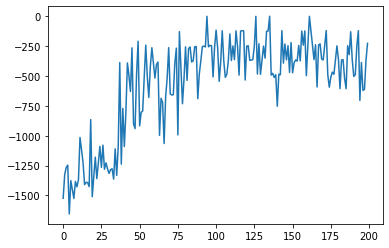

In [7]:
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output


env = gym.make('Pendulum-v0')
agent = DDPG(state_dim=3, action_dim=1, action_max=2)

episode_n = 200
session_len = 200
total_rewards = []

for episode in range(episode_n):
    state = env.reset()
    total_reward = 0
    for _ in range(session_len):
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.fit(state, action, reward, done, next_state)
        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)
    plt.plot(total_rewards)
    clear_output(True)    
    plt.show()